This notebook demonstrates how to evaluate the performance of a simple 1/n portfolio and find the efficient frontier using Monte Carlo simulations and optimization with SciPy.

You can freely change the following:

- **RISKY_ASSETS**: The list of ticker symbols for the assets you want to include in your portfolio.
- **START_DATE** and **END_DATE**: The time period for which you want to download historical price data.
- **N_PORTFOLIOS**: The number of random portfolios to simulate in the Monte Carlo simulation (a higher number will give a more detailed efficient frontier but take longer to run).
- **N_DAYS**: The number of trading days in a year (used for annualizing returns and volatility).

#Evaluating the performance of a basic 1/n portfolio

In [70]:
!pip install --upgrade yfinance

In [71]:
!pip install requests pandas numpy matplotlib statsmodels cufflinks seaborn pyfolio tabulate

In [72]:
import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tabulate import tabulate

In [73]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [74]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

RISKY_ASSETS = ['BDMN.JK', 'BBCA.JK', 'ANTM.JK', 'ISAT.JK']
START_DATE = '2020-07-01'
END_DATE = '2025-06-30'

n_assets = len(RISKY_ASSETS)

prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE)
prices_df

/tmp/ipython-input-2477985527.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  4 of 4 completed


Price             Close                                                High  \
Ticker          ANTM.JK      BBCA.JK      BDMN.JK      ISAT.JK      ANTM.JK   
Date                                                                          
2020-07-01   495.012146  5133.784180  2298.173340   454.833649   507.387450   
2020-07-02   503.262360  5195.744141  2331.845947   454.833649   503.262360   
2020-07-03   495.012146  5195.744141  2340.264404   470.517548   507.387450   
2020-07-06   528.013000  5253.277344  2357.100586   490.122559   528.013000   
2020-07-07   536.263123  5301.959473  2365.518799   501.885437   552.763526   
...                 ...          ...          ...          ...          ...   
2025-06-20  3048.227295  8700.000000  2480.000000  2100.000000  3181.587239   
2025-06-23  3190.000000  8625.000000  2410.000000  2020.000000  3290.000000   
2025-06-24  3090.000000  8775.000000  2430.000000  2060.000000  3240.000000   
2025-06-25  2930.000000  8600.000000  2450.000000  2050.000000  3140.000000   
2025-06-26  2940.000000  8650.000000  2440.000000  2090.000000  2970.000000   

Price                                                      Low               \
Ticker          BBCA.JK      BDMN.JK      ISAT.JK      ANTM.JK      BBCA.JK   
Date                                                                          
2020-07-01  5133.784180  2306.591557   466.596588   490.887045  5023.142279   
2020-07-02  5195.744141  2331.845947   466.596588   486.761954  5098.379259   
2020-07-03  5226.723876  2382.355491   486.201466   495.012146  5169.190082   
2020-07-06  5253.277344  2365.518802   497.964520   495.012188  5178.040853   
2020-07-07  5306.385148  2373.937015   515.608867   528.012921  5222.297310   
...                 ...          ...          ...          ...          ...   
2025-06-20  8875.000000  2480.000000  2120.000000  3010.124454  8625.000000   
2025-06-23  8700.000000  2430.000000  2090.000000  3060.000000  8500.000000   
2025-06-24  8850.000000  2470.000000  2090.000000  3070.000000  8700.000000   
2025-06-25  8775.000000  2460.000000  2070.000000  2900.000000  8475.000000   
2025-06-26  8650.000000  2450.000000  2120.000000  2830.000000  8525.000000   

Price                                        Open                            \
Ticker          BDMN.JK      ISAT.JK      ANTM.JK      BBCA.JK      BDMN.JK   
Date                                                                          
2020-07-01  2281.336905   454.833649   503.262348  5045.270659  2281.336905   
2020-07-02  2289.754865   450.912669   495.012157  5111.656288  2298.173082   
2020-07-03  2323.427970   456.794119   507.387450  5195.744141  2340.264404   
2020-07-06  2306.591288   470.517656   499.137290  5186.892205  2348.682370   
2020-07-07  2340.264150   484.241027   532.138022  5257.702716  2373.937015   
...                 ...          ...          ...          ...          ...   
2025-06-20  2400.000000  2080.000000  3172.061529  8700.000000  2410.000000   
2025-06-23  2370.000000  1900.000000  3070.000000  8575.000000  2380.000000   
2025-06-24  2410.000000  2040.000000  3190.000000  8725.000000  2450.000000   
2025-06-25  2420.000000  2050.000000  3100.000000  8725.000000  2430.000000   
2025-06-26  2410.000000  2040.000000  2930.000000  8525.000000  2450.000000   

Price                       Volume                                
Ticker          ISAT.JK    ANTM.JK    BBCA.JK  BDMN.JK   ISAT.JK  
Date                                                              
2020-07-01   460.715118   21393300   63959000   859800   8444000  
2020-07-02   454.833649   41575700   75585500   688400  11791600  
2020-07-03   460.715099   30660200   52219000  2528000  34390000  
2020-07-06   470.517656  133412200   67800000   499300  49955200  
2020-07-07   496.003967  234409300   74168000   790500  46987600  
...                 ...        ...        ...      ...       ...  
2025-06-20  2090.000000  223744600  445915100   954900  18810900  
2025-06-2

Downloaded 1198 rows of data.


<Axes: title={'center': 'Stock prices of the considered assets'}, xlabel='Date'>

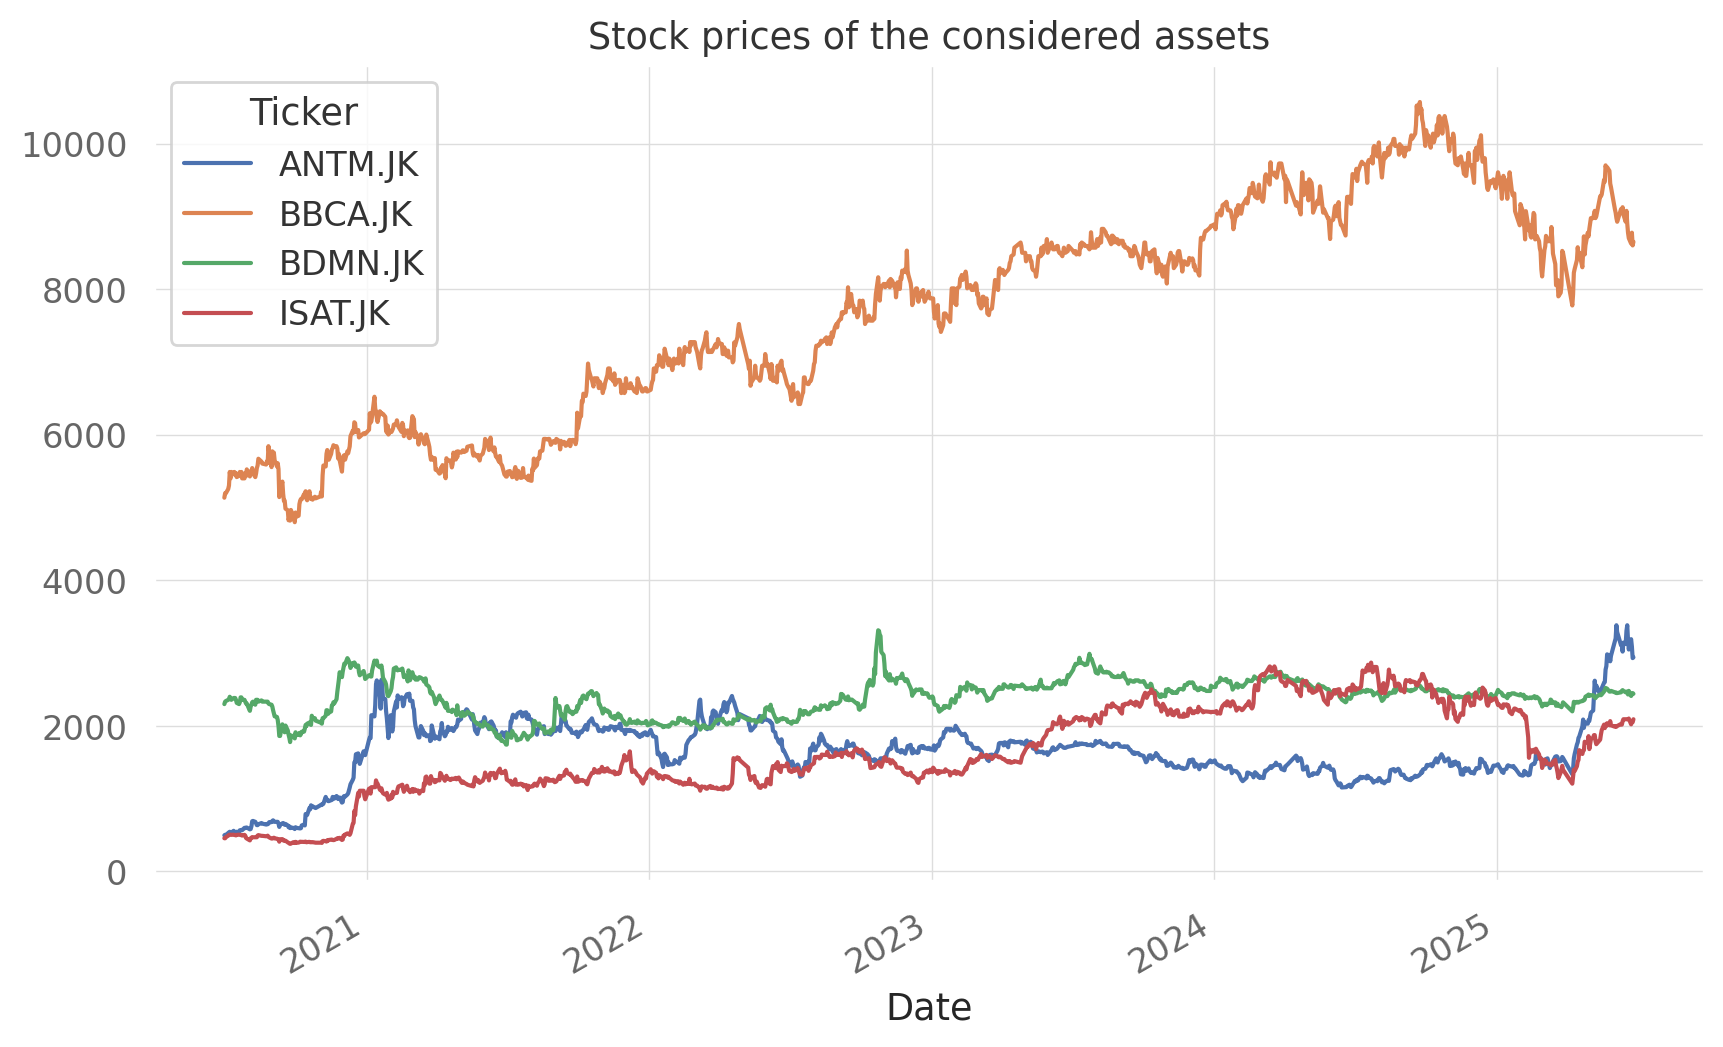

In [75]:
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Close'].plot(title='Stock prices of the considered assets')

Calculate individual asset returns:

In [76]:
returns = prices_df['Close'].pct_change(fill_method=None).dropna()

In [77]:
prices_df.fillna(method='ffill', inplace=True)
returns = prices_df['Close'].pct_change().dropna()

/tmp/ipython-input-4019534680.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices_df.fillna(method='ffill', inplace=True)


Define the Weights

In [78]:
portfolio_weights = n_assets * [1 / n_assets]

Calculate portfolio returns:

In [79]:
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                             index=returns.index)

Create the tear sheet (simple variant):

In [80]:
pip install quantstats

In [81]:
portfolio_returns = pd.Series(portfolio_returns)
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
annualized_return = portfolio_returns.mean() * 252
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

max_drawdown = (portfolio_returns.cumsum().min() - portfolio_returns.cumsum().max()) / portfolio_returns.cumsum().max()
calmar_ratio = annualized_return / abs(max_drawdown)
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()

cumulative_returns = (1 + portfolio_returns).cumprod() - 1
max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()

downside_returns = portfolio_returns[portfolio_returns < 0]
sortino_ratio = annualized_return / downside_returns.std() * np.sqrt(252)

skew = portfolio_returns.skew()
kurtosis = portfolio_returns.kurtosis()
tail_ratio = portfolio_returns[portfolio_returns < 0].mean() / portfolio_returns[portfolio_returns > 0].mean()
stability = 1 / portfolio_returns.var()
var = np.percentile(portfolio_returns, 5)

# Print out the metrics
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Skew: {skew:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")
print(f"Tail Ratio: {tail_ratio:.2f}")
print(f"Stability: {stability:.2f}")
print(f"Value at Risk (VaR): {var:.2%}")

Annualized Return: 28.00%
Annualized Volatility: 24.50%
Sharpe Ratio: 1.14
Calmar Ratio: 0.27
Max Drawdown: 77.06%
Sortino Ratio: 466.09
Skew: 0.61
Kurtosis: 6.38
Tail Ratio: -0.84
Stability: 4198.38
Value at Risk (VaR): -2.15%


Plot the Portfolio Cumulative Returns

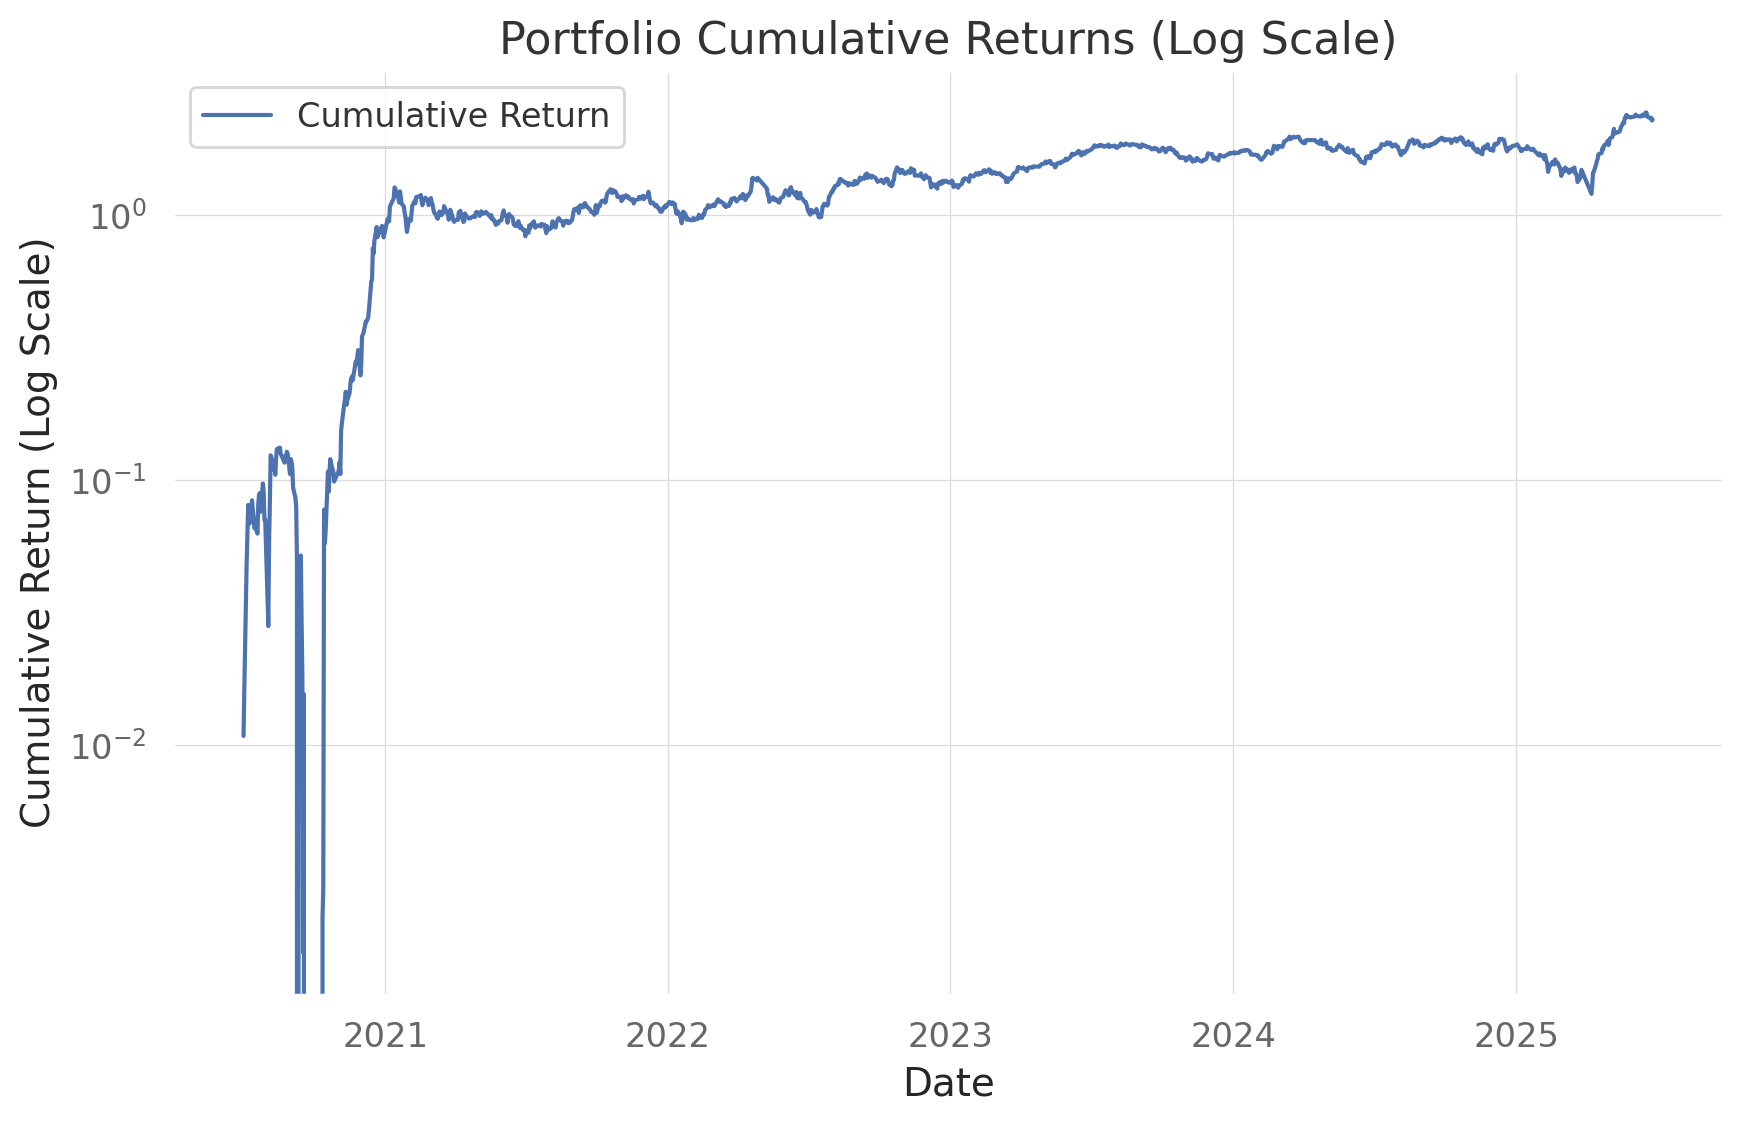

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Cumulative Return', color='b')
plt.yscale('log')
plt.title('Portfolio Cumulative Returns (Log Scale)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (Log Scale)', fontsize=14)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

Rolling Sharpe Ratio:

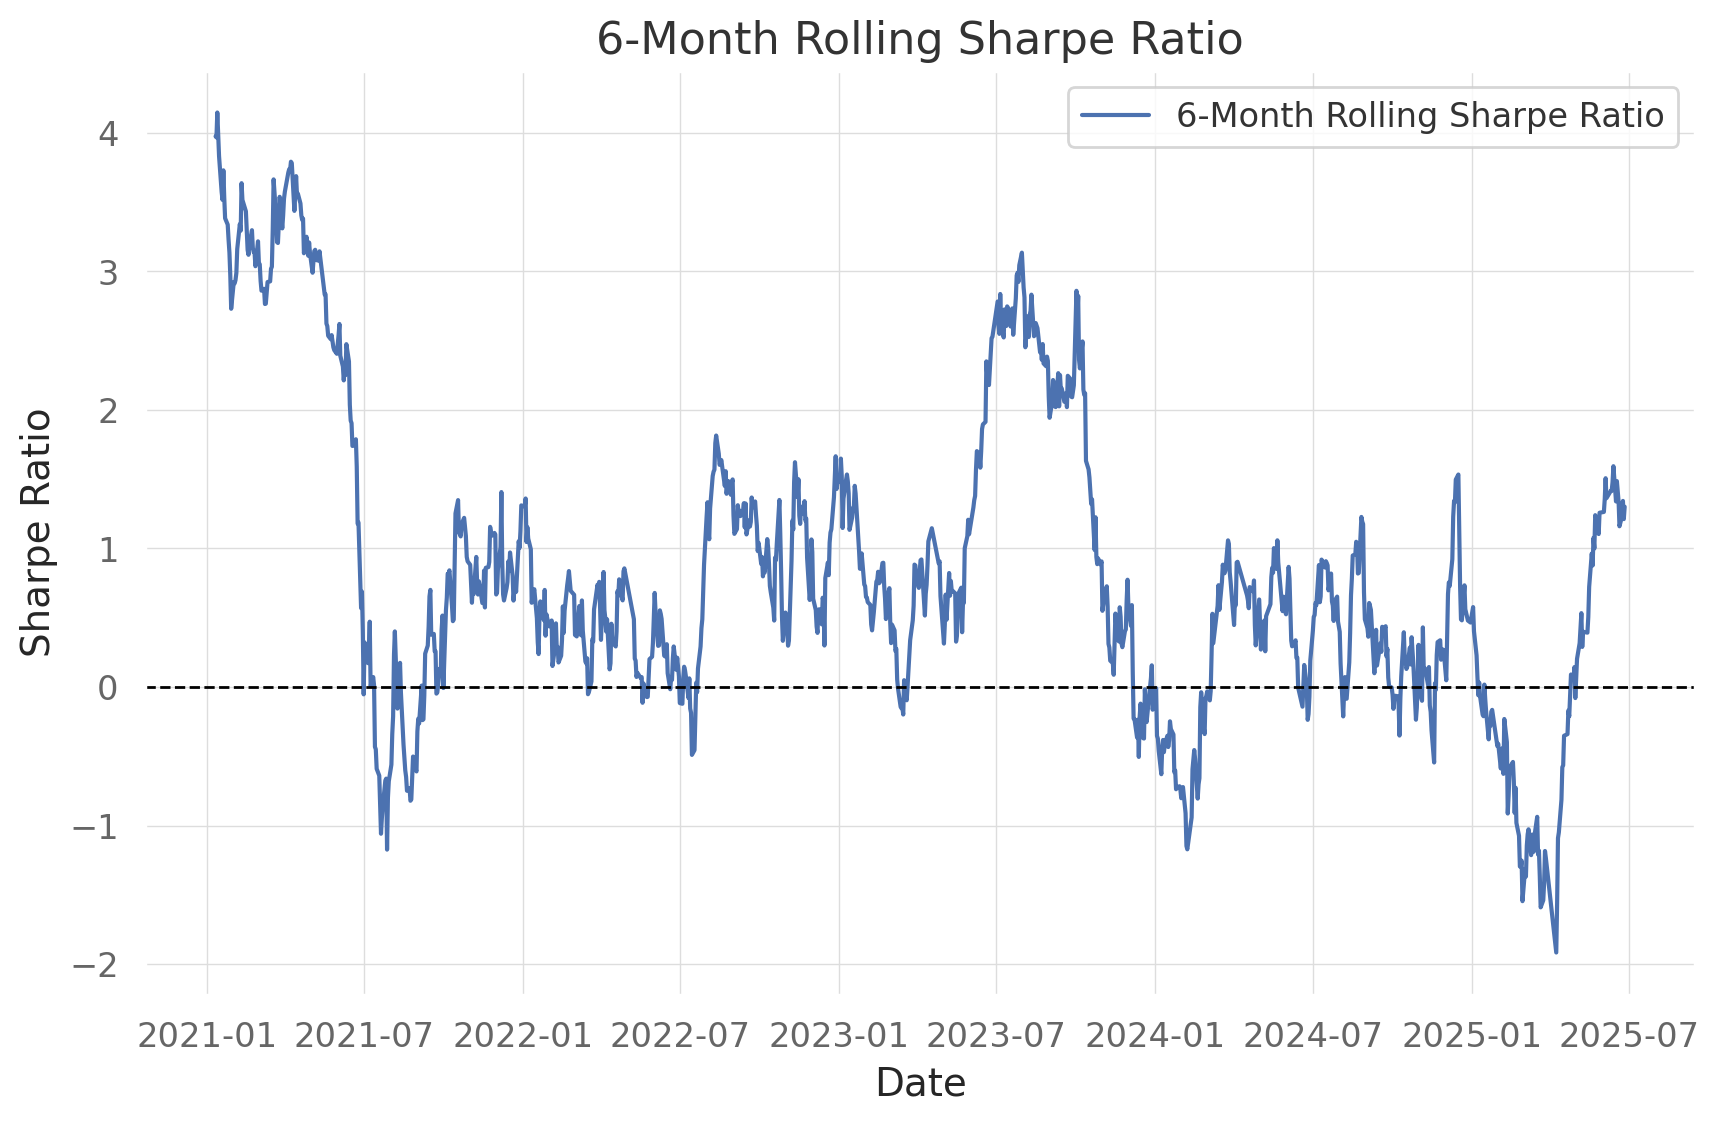

In [83]:
# Define the rolling window (6 months)
window = 6 * 21  # 6 months with 21 trading days per month (approximately 126 days)

rolling_mean = portfolio_returns.rolling(window=window).mean()
rolling_volatility = portfolio_returns.rolling(window=window).std()

rolling_sharpe_ratio = rolling_mean / rolling_volatility * np.sqrt(252)

plt.figure(figsize=(10, 6))
plt.plot(rolling_sharpe_ratio, label='6-Month Rolling Sharpe Ratio', color='b')

plt.title('6-Month Rolling Sharpe Ratio', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sharpe Ratio', fontsize=14)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

Underwater Plot

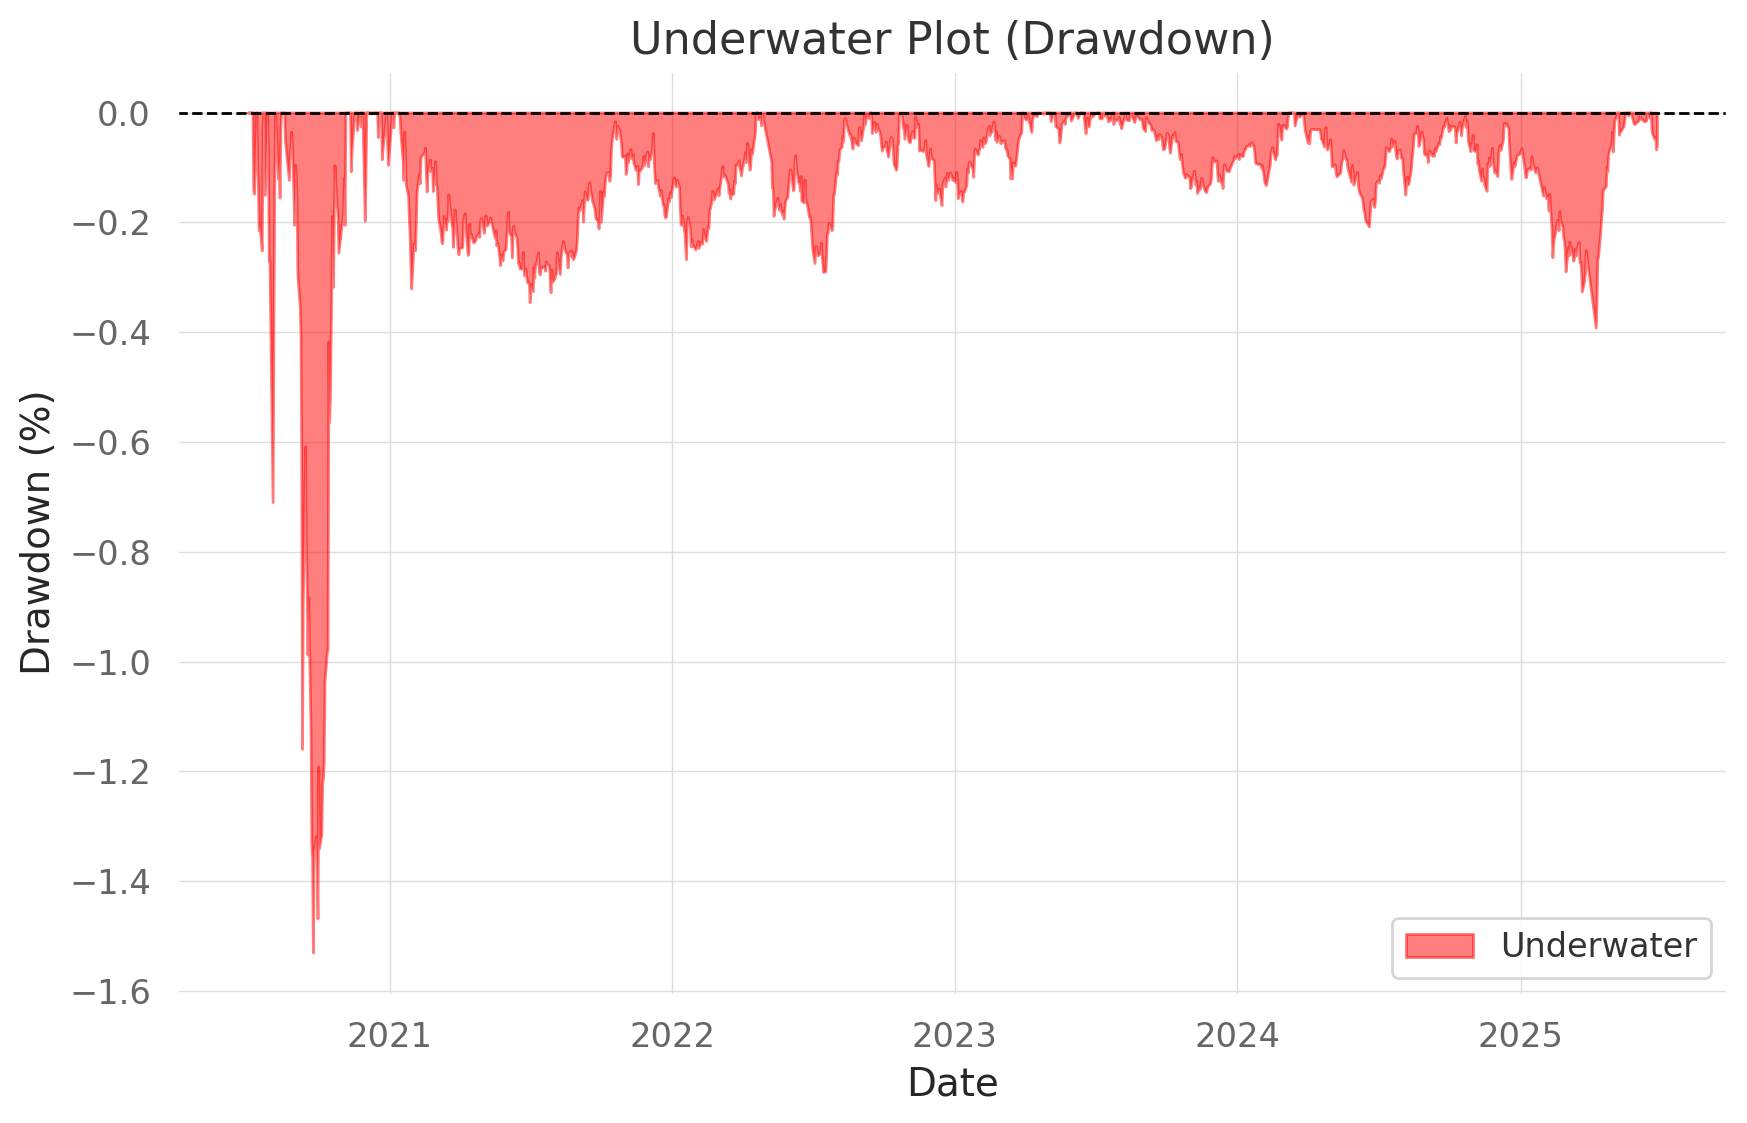

In [84]:
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max

plt.figure(figsize=(10, 6))
plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.5, label='Underwater')
plt.title('Underwater Plot (Drawdown)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Drawdown (%)', fontsize=14)
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline (0% drawdown)
plt.grid(True)
plt.legend()
plt.show()

#Finding the Efficient Frontier using Monte Carlo simulations

In [85]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252

In [86]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

/tmp/ipython-input-1576605319.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  4 of 4 completed

Downloaded 1198 rows of data.


Calculate annualized average returns and the corresponding standard deviation:

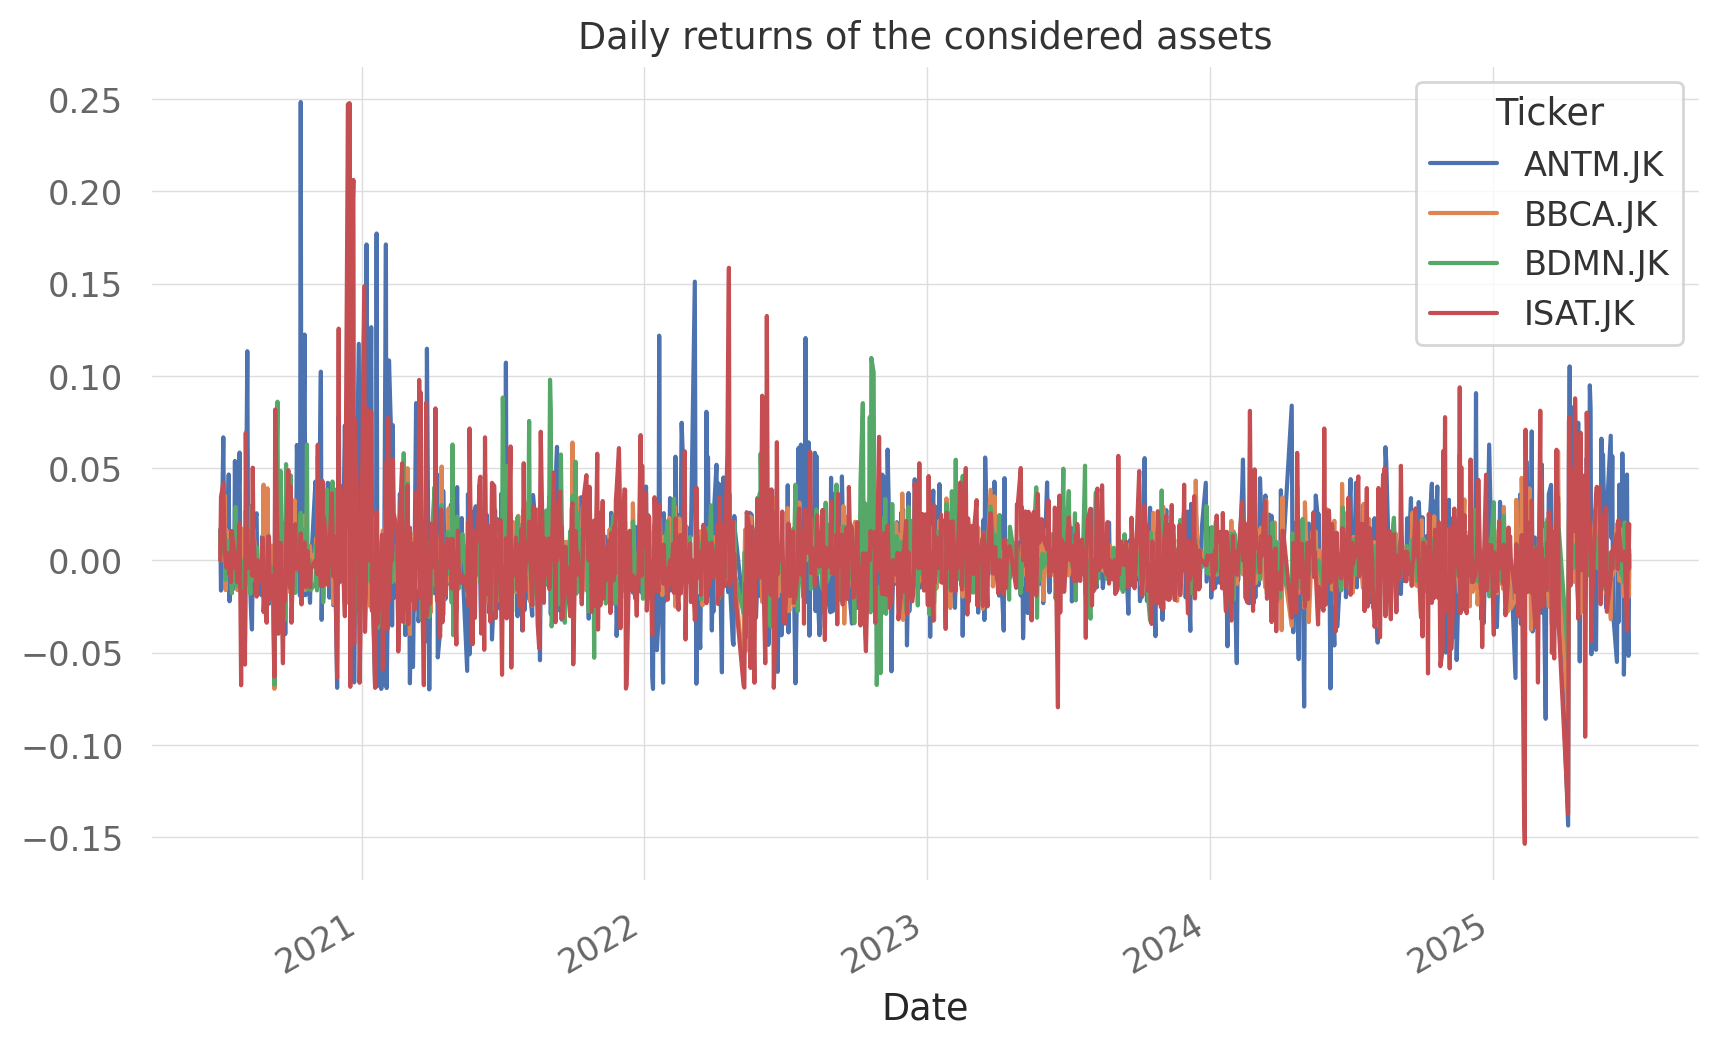

In [87]:
returns_df = prices_df['Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
returns_df.plot(title='Daily returns of the considered assets');

Simulate random portfolio weights:

In [88]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

Calculate portfolio metrics:

In [89]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,
                                   np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

Create a joint DataFrame with all data:

In [90]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                'volatility': portf_vol,
                                'sharpe_ratio': portf_sharpe_ratio})

Locate the points creating the Efficient Frontier:

In [91]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
                           portf_results_df.returns.max(),
                           N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

Plot the Efficient Frontier:

/tmp/ipython-input-34738572.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=avg_returns[asset_index],


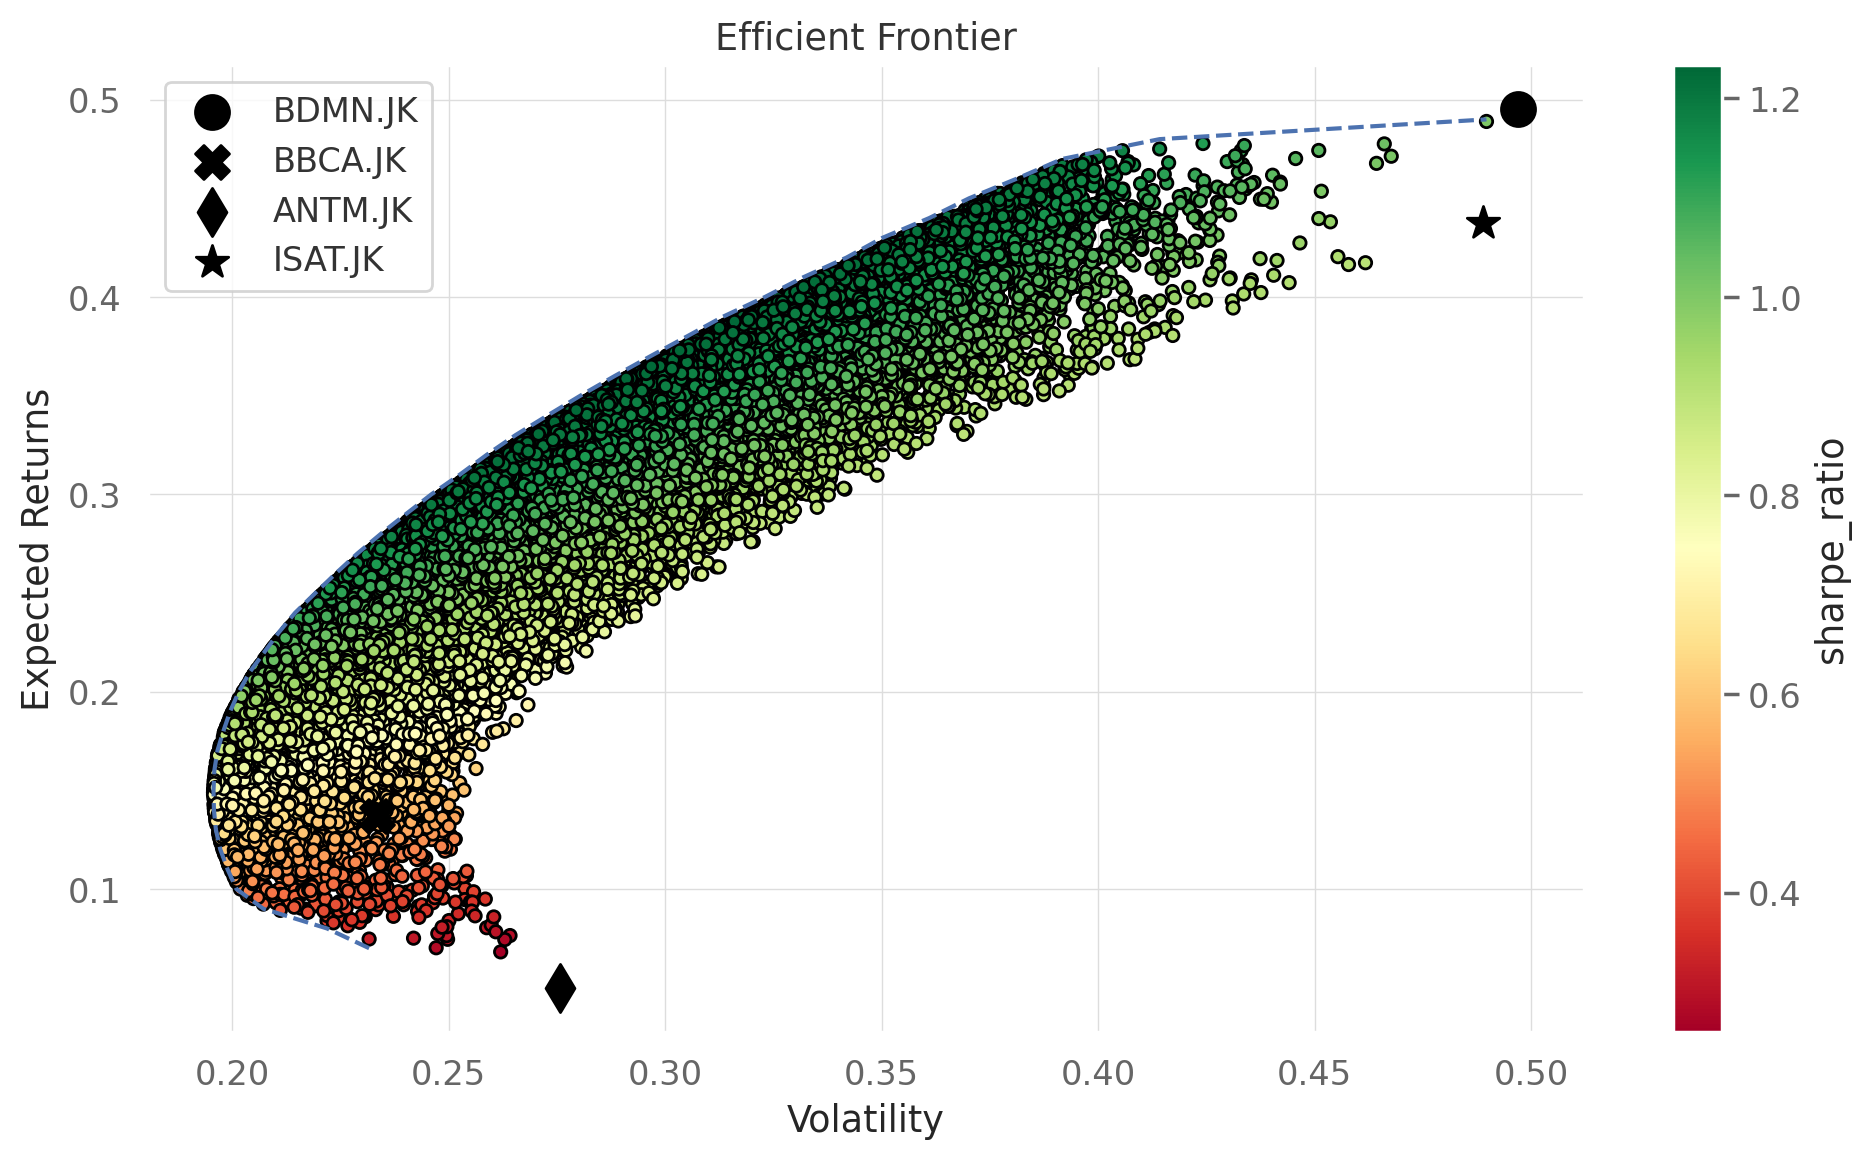

In [92]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                     y='returns', c='sharpe_ratio',
                     cmap='RdYlGn', edgecolors='black',
                     ax=ax)
ax.set(xlabel='Volatility',
      ylabel='Expected Returns',
      title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
              y=avg_returns[asset_index],
              marker=MARKS[asset_index],
              s=150,
              color='black',
              label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

#Finding the Efficient Frontier using optimization with scipy

Finding the Efficient Frontier using optimization with scipy

In [93]:
import numpy as np
import scipy.optimize as sco

Define functions calculating portfolio returns and volatility:

In [94]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

Define the function calculating the efficient frontier:

In [95]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):

    efficient_portfolios = []

    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]

    for ret in rtns_range:
        constraints = ({'type': 'eq',
                       'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                      {'type': 'eq',
                      'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess,
                                          args=args, method='SLSQP',
                                          constraints=constraints,
                                          bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)

    return efficient_portfolios

Define the considered range of returns:

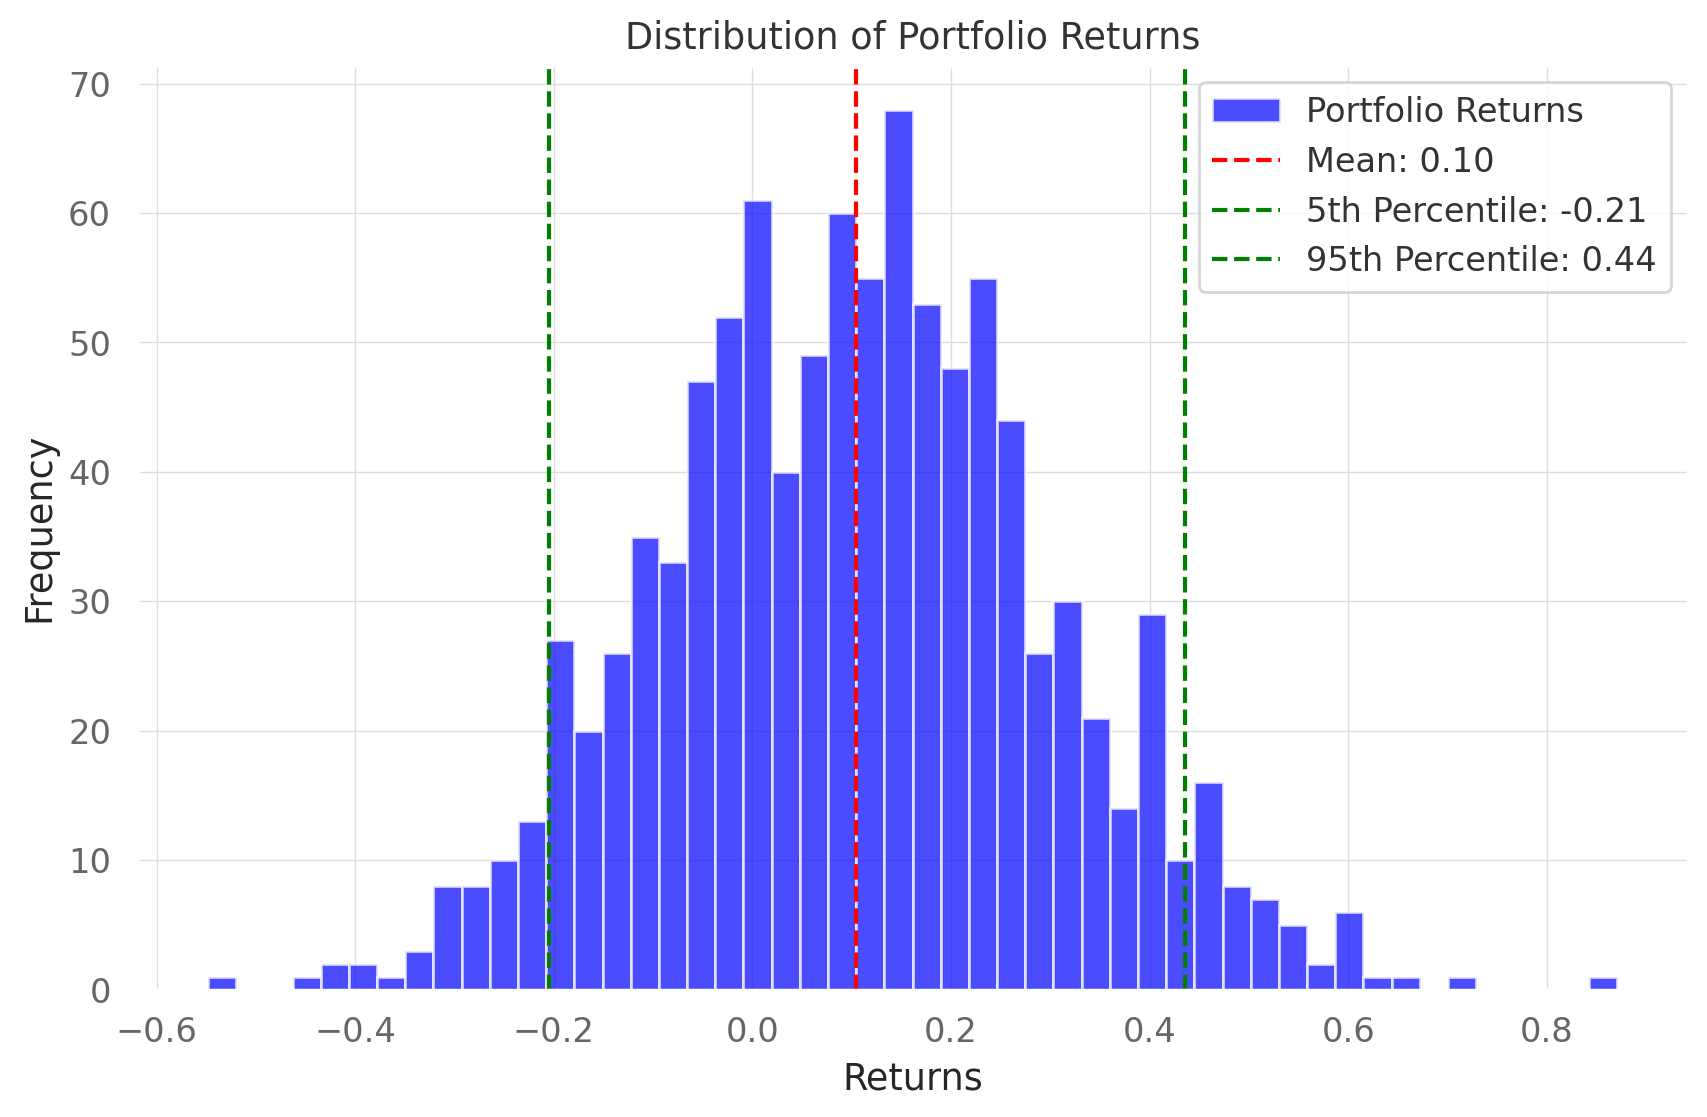

Mean Return: 0.10
Standard Deviation: 0.20
Range based on mean ± 3*std: -0.48 to 0.69
Range based on 5th to 95th percentile: -0.21 to 0.44


In [96]:
# Example: Simulating portfolio returns as a random walk (replace this with your actual portfolio returns)
np.random.seed(42)  # For reproducibility
portfolio_returns = np.random.normal(loc=0.1, scale=0.2, size=1000)  # mean=10%, std=20%

mean_return = np.mean(portfolio_returns)
std_return = np.std(portfolio_returns)

rtns_range_1 = np.linspace(mean_return - 3*std_return, mean_return + 3*std_return, 200)

lower_percentile = np.percentile(portfolio_returns, 5)
upper_percentile = np.percentile(portfolio_returns, 95)
rtns_range_2 = np.linspace(lower_percentile, upper_percentile, 200)

plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, alpha=0.7, label="Portfolio Returns", color='blue')
plt.axvline(mean_return, color='red', linestyle='--', label=f"Mean: {mean_return:.2f}")
plt.axvline(lower_percentile, color='green', linestyle='--', label=f"5th Percentile: {lower_percentile:.2f}")
plt.axvline(upper_percentile, color='green', linestyle='--', label=f"95th Percentile: {upper_percentile:.2f}")
plt.title("Distribution of Portfolio Returns")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Mean Return: {mean_return:.2f}")
print(f"Standard Deviation: {std_return:.2f}")
print(f"Range based on mean ± 3*std: {rtns_range_1[0]:.2f} to {rtns_range_1[-1]:.2f}")
print(f"Range based on 5th to 95th percentile: {rtns_range_2[0]:.2f} to {rtns_range_2[-1]:.2f}")

I choose to run based on 5th to 95th percentile
(focuses on the central portion of the data and avoids extreme outliers, the purpose is to focus on typical returns (without extreme values), use this range.)

In [97]:
rtns_range = np.linspace(-0.21, 0.44, 200)

Calculate the Efficient Frontier:

In [98]:
efficient_portfolios = get_efficient_frontier(avg_returns,
                                             cov_mat,
                                             rtns_range)

Extract the volatilities of the efficient portfolios:

In [99]:
vols_range = [x['fun'] for x in efficient_portfolios]

Plot the calculated Efficient Frontier, together with the simulated portfolios:

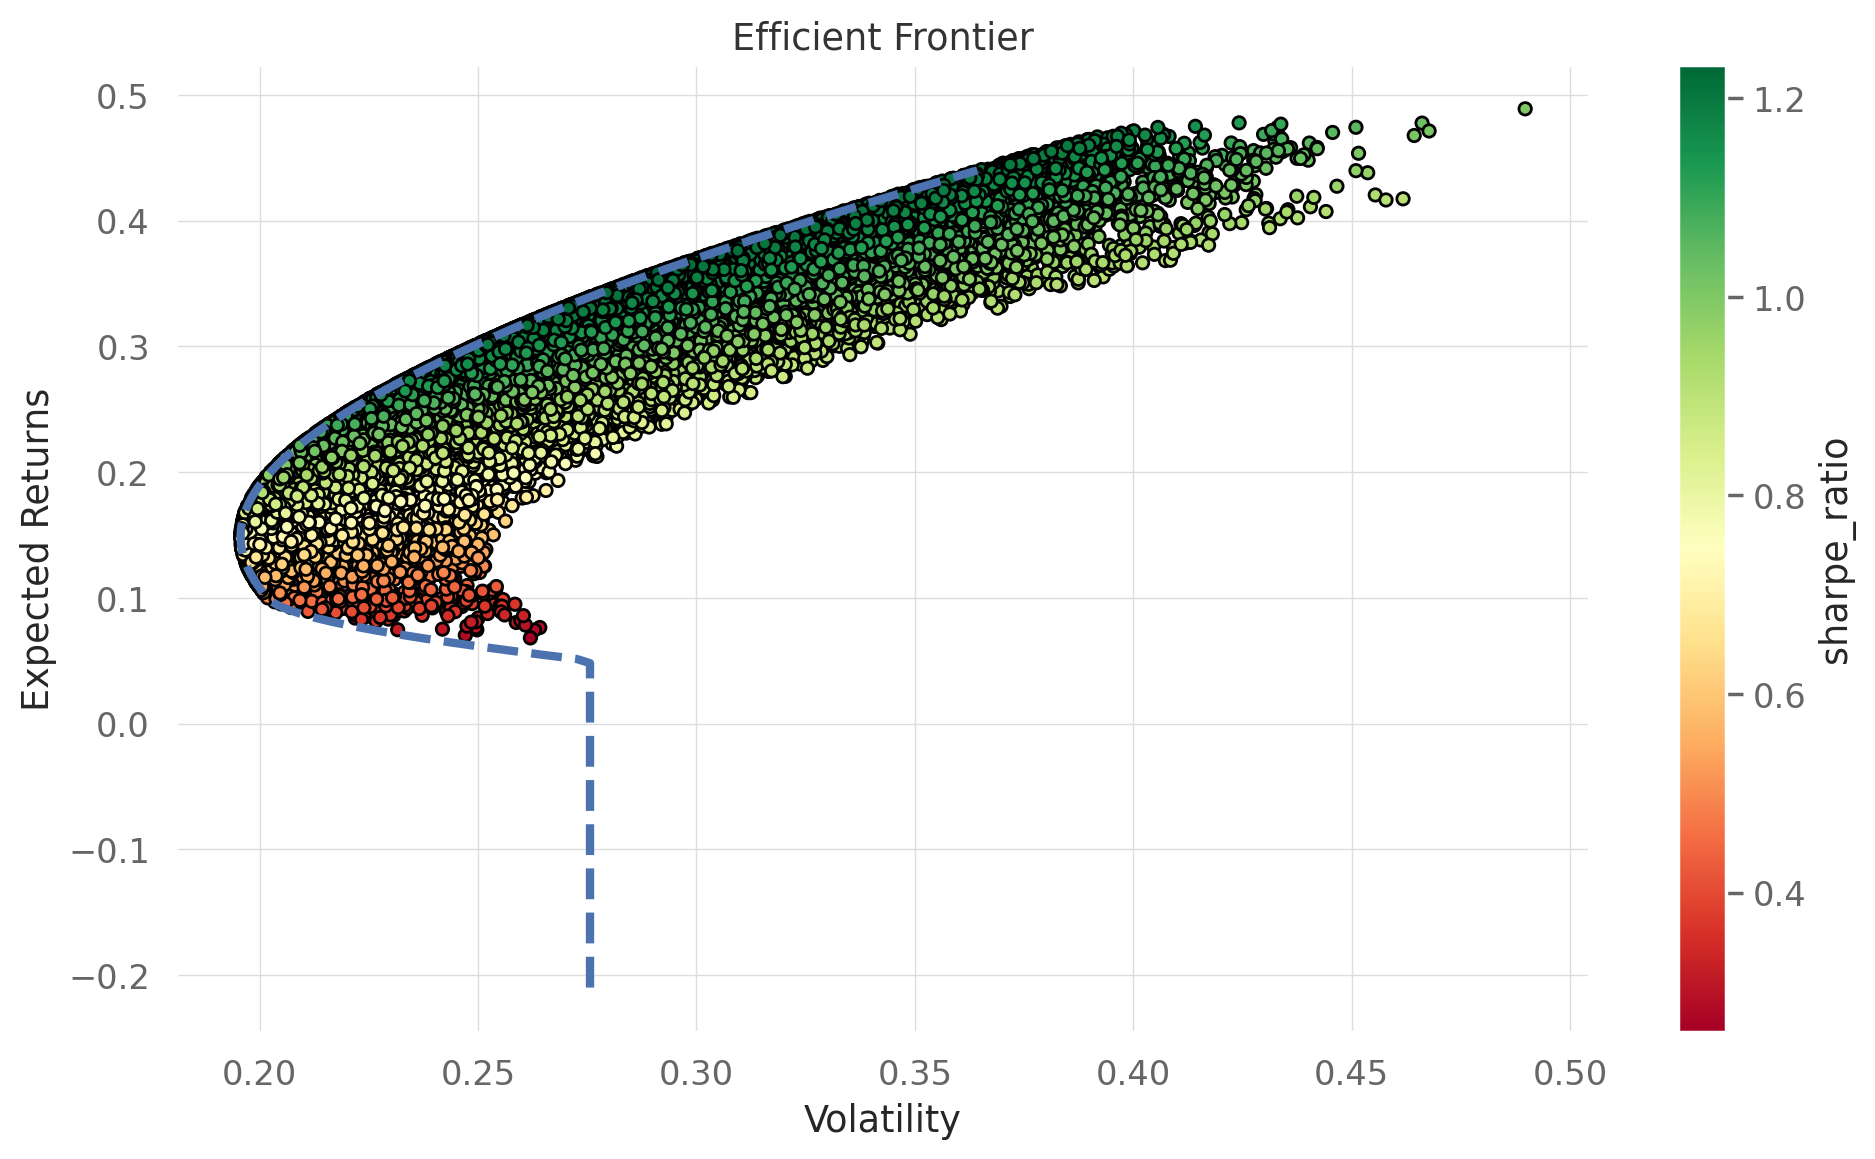

In [100]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                     y='returns', c='sharpe_ratio',
                     cmap='RdYlGn', edgecolors='black',
                     ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
      ylabel='Expected Returns',
      title='Efficient Frontier')

plt.tight_layout()
plt.show()

Identify the minimum volatility portfolio:

In [101]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                'Volatility': min_vol_portf_vol,
                'Sharpe Ratio': (min_vol_portf_rtn /
                                min_vol_portf_vol)}

min_vol_portf

{'Return': np.float64(0.1492964824120603),
 'Volatility': np.float64(0.1956432772088203),
 'Sharpe Ratio': np.float64(0.7631056100778172)}

Print performance summary:

In [102]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 14.93% Volatility: 19.56% Sharpe Ratio: 76.31% 
Weights
BDMN.JK: 7.26% BBCA.JK: 54.22% ANTM.JK: 33.42% ISAT.JK: 5.10% 

The minimum volatility portfolio is the portfolio on the efficient frontier with the lowest risk (volatility). While it doesn't offer the highest expected return, it provides the best return for the amount of risk taken among all possible portfolios.

In this case:
- **Return:** The expected annualized return for this portfolio is 14.93%.
- **Volatility:** The expected annualized volatility (risk) for this portfolio is 19.56%.
- **Sharpe Ratio:** The Sharpe Ratio of 0.76 indicates that for every unit of risk (volatility) taken, the portfolio is expected to generate 0.76 units of return above the risk-free rate (assuming a risk-free rate of 0 for simplicity in this calculation). A higher Sharpe Ratio is generally preferred.

The weights show the allocation to each asset in this minimum volatility portfolio:
- BDMN.JK: 7.26%
- BBCA.JK: 54.22%
- ANTM.JK: 33.42%
- ISAT.JK: 5.10%

This indicates that to achieve the lowest volatility for this set of assets, the portfolio should be primarily weighted towards BBCA.JK and ANTM.JK.